# Requirements

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from xgboost import XGBRegressor

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for the Amazon stock. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- open - the open price of the stock
- high - the high price of the stock
- low - the low price of the stock
- volume - the volume trades
- close - the close price of the stock

Target:
close

Load the dataset into a `pandas` data frame.

In [2]:
df = pd.read_csv('data/amazon_stock_price.csv')

In [3]:
df.shape

(6685, 6)

In [4]:
df.head()

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


Explore the dataset using visualizations of your choice.

In [5]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)
df.head()

,open,high,low,close,volume
date,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


<Axes: >

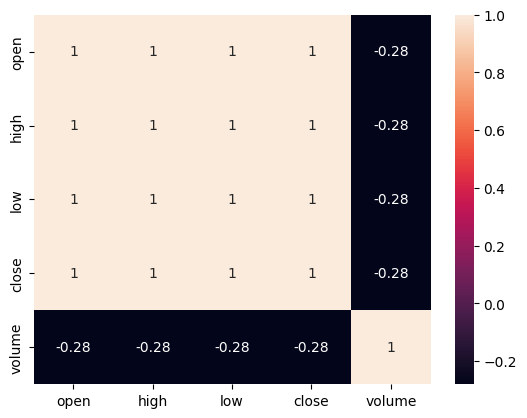

In [6]:
sns.heatmap(df.corr(), annot=True)

# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [7]:
df.drop(columns=['high', 'low'])

,open,close,volume
date,,,
1997-05-15,0.1219,0.0979,1443120000
1997-05-16,0.0984,0.0865,294000000
1997-05-19,0.0880,0.0854,122136000
1997-05-20,0.0865,0.0818,109344000
1997-05-21,0.0818,0.0714,377064000
...,...,...,...
2023-11-30,144.7600,146.0900,65814000
2023-12-01,146.0000,147.0300,39924600
2023-12-04,145.2500,144.8400,48294200


In [8]:
features = ["open", "volume"]
target = "close"

In [9]:
lags = range(7, 0, -1)
list(lags)

[7, 6, 5, 4, 3, 2, 1]

In [10]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df.head()

,open,high,low,close,volume,open_7,volume_7,close_7,open_6,volume_6,...,close_4,open_3,volume_3,close_3,open_2,volume_2,close_2,open_1,volume_1,close_1
date,,,,,,,,,,,,,,,,,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1219,1.443120e+09,0.0979
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1219,1.443120e+09,0.0979,0.0984,2.940000e+08,0.0865
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000,NaN,NaN,NaN,NaN,NaN,...,NaN,0.1219,1.443120e+09,0.0979,0.0984,2.940000e+08,0.0865,0.0880,1.221360e+08,0.0854
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000,NaN,NaN,NaN,NaN,NaN,...,0.0979,0.0984,2.940000e+08,0.0865,0.0880,1.221360e+08,0.0854,0.0865,1.093440e+08,0.0818


In [11]:
df.drop(columns=['high', 'low'], inplace=True)
df.dropna(axis=0, inplace=True)
df.head()

,open,close,volume,open_7,volume_7,close_7,open_6,volume_6,close_6,open_5,...,close_4,open_3,volume_3,close_3,open_2,volume_2,close_2,open_1,volume_1,close_1
date,,,,,,,,,,,,,,,,,,,,,
1997-05-27,0.0755,0.0792,173952000,0.1219,1.443120e+09,0.0979,0.0984,294000000.0,0.0865,0.0880,...,0.0818,0.0818,377064000.0,0.0714,0.0719,235536000.0,0.0698,0.0703,318744000.0,0.0750
1997-05-28,0.0812,0.0766,91488000,0.0984,2.940000e+08,0.0865,0.0880,122136000.0,0.0854,0.0865,...,0.0714,0.0719,235536000.0,0.0698,0.0703,318744000.0,0.0750,0.0755,173952000.0,0.0792
1997-05-29,0.0771,0.0753,69456000,0.0880,1.221360e+08,0.0854,0.0865,109344000.0,0.0818,0.0818,...,0.0698,0.0703,318744000.0,0.0750,0.0755,173952000.0,0.0792,0.0812,91488000.0,0.0766
1997-05-30,0.0750,0.0750,51888000,0.0865,1.093440e+08,0.0818,0.0818,377064000.0,0.0714,0.0719,...,0.0750,0.0755,173952000.0,0.0792,0.0812,91488000.0,0.0766,0.0771,69456000.0,0.0753
1997-06-02,0.0755,0.0755,11832000,0.0818,3.770640e+08,0.0714,0.0719,235536000.0,0.0698,0.0703,...,0.0792,0.0812,91488000.0,0.0766,0.0771,69456000.0,0.0753,0.0750,51888000.0,0.0750


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [12]:
X, y = df.drop(columns=[target]), df[target]

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [14]:
forest = RandomForestRegressor()

In [15]:
forest.fit(train_X, train_y)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [16]:
y_pred = forest.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [17]:
r2_score(test_y, y_pred)

-0.8499146760465031

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [27]:
xgb = XGBRegressor()

In [28]:
xgb.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [29]:
y_pred = xgb.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [30]:
r2_score(test_y, y_pred)

-0.9652430364553681